In [1]:
# !pip install torchsummary
from tqdm import tqdm
from torchsummary import summary
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision import datasets
import numpy as np
import matplotlib.pyplot as plt


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.24 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
SEED = 10
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)
device = torch.device("cuda" if cuda else "cpu")
print(device)

CUDA Available? True
cuda


In [3]:
class FitEvaluate:
  def __init__(self,model,device, train_loader,test_loader):
    self.model, self.device, self.train_loader, self.test_loader = model, device, train_loader,test_loader
    self.train_losses,self.test_losses, self.train_acc, self.test_acc= [], [], [], []
    pass

  def train(self, optimizer, epoch):
    try:
      self.model.train()
      pbar = tqdm(self.train_loader)
      correct = 0
      processed = 0
      for batch_idx, (data, target) in enumerate(pbar):
        # get samples
        data, target = data.to(device), target.to(device)

        # Init
        optimizer.zero_grad()

        # Predict
        y_pred = self.model(data)

        # Calculate loss
        loss = F.nll_loss(y_pred, target)
        self.train_losses.append(loss)

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update pbar-tqdm

        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        self.train_acc.append(100*correct/processed)

    except Exception as ex:
      print(f"Exception in train function: {ex}")

  def test(self):
    try:
      self.model.eval()
      test_loss = 0
      correct = 0
      with torch.no_grad():
          for data, target in self.test_loader:
              data, target = data.to(device), target.to(device)
              output = model(data)
              test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
              pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
              correct += pred.eq(target.view_as(pred)).sum().item()

      test_loss /= len(self.test_loader.dataset)
      self.test_losses.append(test_loss)

      print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
          test_loss, correct, len(self.test_loader.dataset),
          100. * correct / len(self.test_loader.dataset)))

      self.test_acc.append(100. * correct / len(self.test_loader.dataset))

    except Exception as ex:
        print(f"Exception in test function: {ex}")

  def plot_accuracy_loss(self):
    t = [t_items.item() for t_items in self.train_losses]
    fig, axs = plt.subplots(2,2,figsize=(15,10))
    axs[0, 0].plot(t)
    axs[0, 0].set_title("Training Loss")
    axs[1, 0].plot(self.train_acc[4000:])
    axs[1, 0].set_title("Training Accuracy")
    axs[0, 1].plot(self.test_losses)
    axs[0, 1].set_title("Test Loss")
    axs[1, 1].plot(self.test_acc)
    axs[1, 1].set_title("Test Accuracy")

  def epoch_training(self,optimizer,scheduler = '',EPOCHS=15):
    try:
      for epoch in range(EPOCHS):
          print("EPOCH:", epoch)
          self.train(optimizer, epoch)
          if scheduler:
            scheduler.step()
          self.test()
      self.plot_accuracy_loss()

    except Exception as ex:
      print(f"Exception in test function: {ex}")


In [4]:

# Train data transformations
train_transforms = A.Compose(
    [
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=10, p=0.2),
        A.CoarseDropout(
            p=0.2,
            max_holes=1,
            max_height=16,
            max_width=16,
            min_holes=1,
            min_height=16,
            min_width=16,
            fill_value=(0.4914, 0.4822, 0.4465),
        ),
        A.CenterCrop(height=32, width=32, always_apply=True),
        A.Normalize((0.4914, 0.4822, 0.4465), (0.2463, 0.2428, 0.2607)),
        ToTensorV2(),
    ]
)

# Test data transformations
test_transforms = A.Compose(
    [
        A.Normalize((0.4914, 0.4822, 0.4465), (0.2463, 0.2428, 0.2607)),
        ToTensorV2(),
    ]
)

In [5]:
class CIFAR10WithAlbumentations(torch.utils.data.Dataset):
    def __init__(self, root, train=True, transform=None):
        self.dataset = datasets.CIFAR10(root=root, train=train, download=True)
        self.transform = transform

    def __getitem__(self, index):
        image, label = self.dataset[index]
        image = np.array(image)  # Convert PIL Image to numpy array
        if self.transform:
            image = self.transform(image=image)['image']  # Apply Albumentations transformations
        return image, label

    def __len__(self):
        return len(self.dataset)

In [6]:
# Load CIFAR-10 dataset with no transformations
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to tensors
])

# CIFAR-10 dataset (trainset) without normalization for computing stats
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

# Function to calculate the mean and standard deviation
def calculate_mean_std(dataloader):
    # Initialize variables to accumulate pixel values
    mean = 0.0
    std = 0.0
    total_images_count = 0

    # Iterate through the dataset
    for images, _ in dataloader:
        # Calculate batch size
        batch_size = images.size(0)
        # Sum up the pixel values for each channel
        mean += images.mean([0, 2, 3]) * batch_size
        std += images.std([0, 2, 3]) * batch_size
        total_images_count += batch_size

    # Calculate final mean and std for each channel
    mean /= total_images_count
    std /= total_images_count

    return mean, std

# Get the mean and standard deviation for CIFAR-10 dataset
mean, std = calculate_mean_std(trainloader)

print("Mean for each channel:", mean)
print("Standard Deviation for each channel:", std)

Files already downloaded and verified
Mean for each channel: tensor([0.4914, 0.4822, 0.4465])
Standard Deviation for each channel: tensor([0.2464, 0.2428, 0.2607])


In [7]:
# Load CIFAR-10 with Albumentations transforms
trainset = CIFAR10WithAlbumentations(root='./data', train=True, transform=train_transforms)
testset = CIFAR10WithAlbumentations(root='./data', train=False, transform=test_transforms)

# DataLoader to batch the images
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


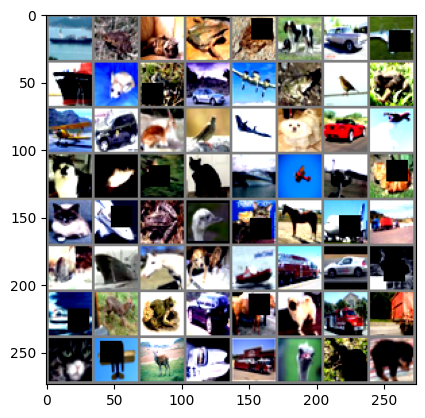

In [8]:
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize the image
    npimg = img.numpy()  # Convert to numpy for plt
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Transpose for correct format
    plt.show()

# Get a batch of training data
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))


In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=24, kernel_size=(3, 3), padding=2, bias=False, dilation = 2),
            nn.BatchNorm2d(24),
            nn.ReLU(),
            self.depthwise_separable_conv(in_channels=24, out_channels=48, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(48),
            nn.ReLU(),
            self.depthwise_separable_conv(in_channels=48, out_channels=64, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=24, kernel_size=(3, 3), padding=1, bias=False, dilation=2, stride=2),
            nn.BatchNorm2d(24),
            nn.ReLU()

        )


        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=24, out_channels=24, kernel_size=(3, 3), padding=2, bias=False, dilation = 2),
            nn.BatchNorm2d(24),
            nn.ReLU(),
            self.depthwise_separable_conv(in_channels=24, out_channels=48, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(48),
            nn.ReLU(),
            self.depthwise_separable_conv(in_channels=48, out_channels=64, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=24, kernel_size=(3, 3), padding=1, bias=False, dilation=2, stride=2),
            nn.BatchNorm2d(24),
            nn.ReLU()
        )

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=24, out_channels=24, kernel_size=(3, 3), padding=2, bias=False, dilation = 2),
            nn.BatchNorm2d(24),
            nn.ReLU(),
            self.depthwise_separable_conv(in_channels=24, out_channels=48, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(48),
            nn.ReLU(),
            self.depthwise_separable_conv(in_channels=48, out_channels=64, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=24, kernel_size=(3, 3), padding=1, bias=False, dilation=2, stride=2),
            nn.BatchNorm2d(24),
            nn.ReLU()
        )

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=24, out_channels=24, kernel_size=(3, 3), padding=2, bias=False, dilation = 2),
            nn.BatchNorm2d(24),
            nn.ReLU(),
            self.depthwise_separable_conv(in_channels=24, out_channels=48, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(48),
            nn.ReLU(),
            self.depthwise_separable_conv(in_channels=48, out_channels=64, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=1, bias=False, dilation=2, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.out = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(64, 10, kernel_size=1),
        )


    def depthwise_separable_conv(self, in_channels, out_channels, kernel_size=3, padding=1):
        """Depthwise Separable Convolution (Depthwise + Pointwise)"""
        # Depthwise Convolution
        depthwise_conv = nn.Conv2d(in_channels=in_channels, out_channels=in_channels,
                                   kernel_size=kernel_size, padding=padding, groups=in_channels,
                                   bias=False)

        # Pointwise Convolution (1x1)
        pointwise_conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                    kernel_size=1, padding=0, bias=False)

        return nn.Sequential(depthwise_conv, pointwise_conv)

    def forward(self, x):
      x = self.convblock1(x)
      x = self.convblock2(x)
      x = self.convblock3(x)
      x = self.convblock4(x)
      x = self.out(x)
      x = x.view(-1, 10)
      return F.log_softmax(x, dim=-1)

In [12]:
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 24, 32, 32]             648
       BatchNorm2d-2           [-1, 24, 32, 32]              48
              ReLU-3           [-1, 24, 32, 32]               0
            Conv2d-4           [-1, 24, 32, 32]             216
            Conv2d-5           [-1, 48, 32, 32]           1,152
       BatchNorm2d-6           [-1, 48, 32, 32]              96
              ReLU-7           [-1, 48, 32, 32]               0
            Conv2d-8           [-1, 48, 32, 32]             432
            Conv2d-9           [-1, 64, 32, 32]           3,072
      BatchNorm2d-10           [-1, 64, 32, 32]             128
             ReLU-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 24, 15, 15]          13,824
      BatchNorm2d-13           [-1, 24, 15, 15]              48
             ReLU-14           [-1, 24,

before convblock1: torch.Size([2, 3, 32, 32])
After convblock1: torch.Size([2, 24, 15, 15])
After convblock2: torch.Size([2, 24, 7, 7])
After convblock3: torch.Size([2, 24, 3, 3])
After convblock4: torch.Size([2, 64, 1, 1])

In [ ]:
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim
optimizer = optim.SGD(model.parameters(), lr=0.2, momentum=0.9)
scheduler = StepLR(optimizer, step_size=4, gamma=0.1)

model_fiteval = FitEvaluate(model, device,trainloader,testloader)
model_fiteval.epoch_training(optimizer, scheduler = scheduler,EPOCHS=50)

EPOCH: 0


Loss=1.4389433860778809 Batch_id=781 Accuracy=26.31: 100%|██████████| 782/782 [00:30<00:00, 25.30it/s]



Test set: Average loss: 1.6751, Accuracy: 3635/10000 (36.35%)

EPOCH: 1


Loss=1.5189262628555298 Batch_id=781 Accuracy=38.34: 100%|██████████| 782/782 [00:31<00:00, 25.08it/s]



Test set: Average loss: 1.4732, Accuracy: 4447/10000 (44.47%)

EPOCH: 2


Loss=1.3213834762573242 Batch_id=781 Accuracy=46.78: 100%|██████████| 782/782 [00:31<00:00, 24.99it/s]



Test set: Average loss: 1.2658, Accuracy: 5232/10000 (52.32%)

EPOCH: 3


Loss=1.9569507837295532 Batch_id=781 Accuracy=51.79: 100%|██████████| 782/782 [00:30<00:00, 25.88it/s]



Test set: Average loss: 1.2653, Accuracy: 5425/10000 (54.25%)

EPOCH: 4


Loss=1.2396087646484375 Batch_id=781 Accuracy=59.32: 100%|██████████| 782/782 [00:30<00:00, 25.87it/s]



Test set: Average loss: 1.0013, Accuracy: 6388/10000 (63.88%)

EPOCH: 5


Loss=1.1331233978271484 Batch_id=781 Accuracy=60.84: 100%|██████████| 782/782 [00:29<00:00, 26.12it/s]



Test set: Average loss: 0.9948, Accuracy: 6354/10000 (63.54%)

EPOCH: 6


Loss=1.0096416473388672 Batch_id=584 Accuracy=61.44:  75%|███████▍  | 585/782 [00:21<00:06, 29.93it/s]